In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings('ignore')

In [2]:
dataset_filepath = os.getenv("HOME") + '/aiffel/stock_prediction/data/daily-min-temperatures.csv'
df = pd.read_csv(dataset_filepath)
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [3]:
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


```pd.read_csv(parse_dates=Ture)```옵션을 통해 date형식의 컬럼을 index로 지정할 수 있다
series로 출력하더라도 index가 포함됨

In [4]:
ts1 = df['Temp']
print(type(ts1))
ts1.head()

<class 'pandas.core.series.Series'>


Date
1981-01-01    20.7
1981-01-02    17.9
1981-01-03    18.8
1981-01-04    14.6
1981-01-05    15.8
Name: Temp, dtype: float64

## 시계열 안정성의 정성적 분석

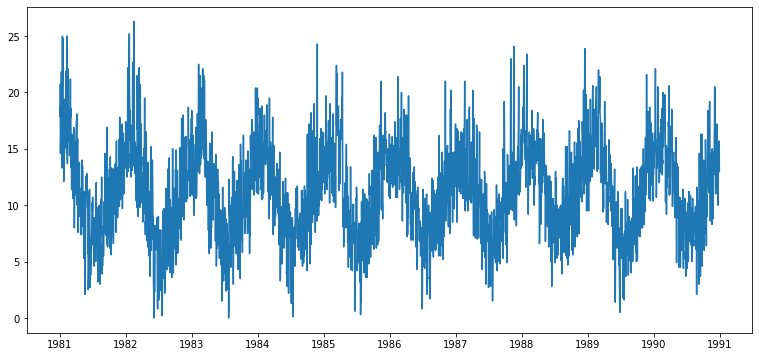

In [5]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6   # matlab 차트 기본 크기를 13x6으로 지정

plt.plot(ts1)

### 시간 결측치 확인 후 처리
Nan 데이터 처리 방법
1. 결측치 데이터 모두 삭제(drop)
2. 결측치 양옆 값들을 이용해서 적절히 보간(interpolate)

In [6]:
ts1[ts1.isna()]

Series([], Name: Temp, dtype: float64)

Series([], Name: Temp, dtype: float64)


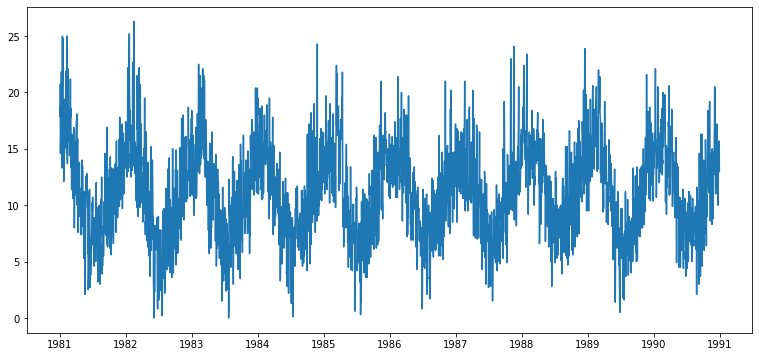

In [7]:
ts1 = ts1.interpolate(method='time')

print(ts1[ts1.isna()])

plt.plot(ts1)

In [8]:
def plot_rolling_statistics(timeseries, window=12):
    # rolling 메소드를 사용하여 윈도우를 옮겨기면서 평균, 분산 계산
    rolmean = timeseries.rolling(window=window).mean()
    rolstd = timeseries.rolling(window=window).std()
    
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

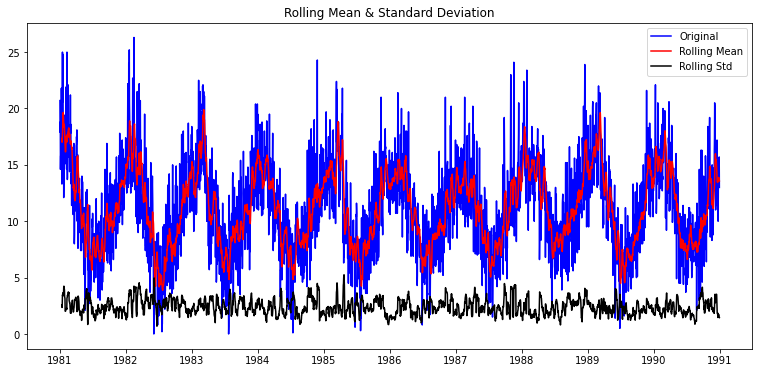

In [9]:
plot_rolling_statistics(ts1, window=12)

---
```International airline passengers``` dataset 월별 항공 승객 수

In [10]:
dataset_file_path = os.getenv("HOME") + '/aiffel/stock_prediction/data/airline-passengers.csv'
df = pd.read_csv(dataset_file_path, index_col='Month', parse_dates=True).fillna(0)
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


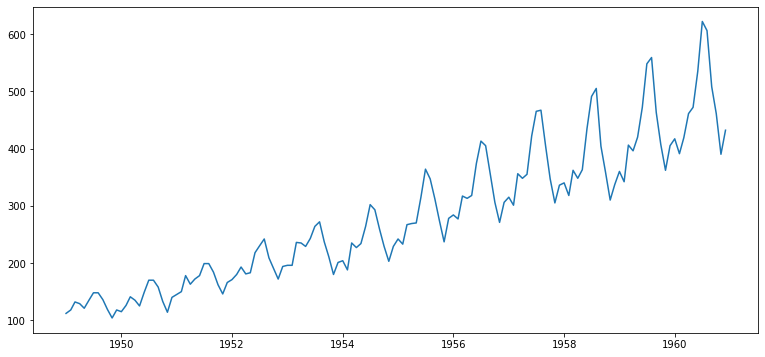

In [11]:
ts2 = df['Passengers']
plt.plot(ts2)

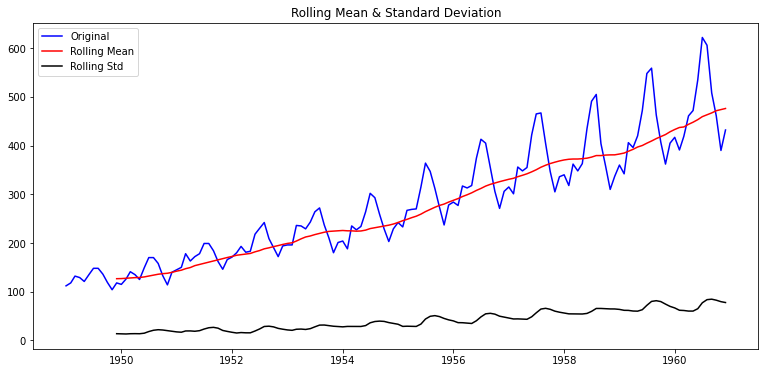

In [12]:
plot_rolling_statistics(ts2, window=12)

* 시간이 지남에 따라 평균과 분산이 함께 증가한다
---
## Stationary 여부를 체크하는 통계적 방법
### Augmented Dickey-Fuller Test, ADF Test
1. `주어진 시계열 데이터가 nonstationary 하다`라는 `귀무가설 Null Hypothesis` 를 세운 후,
2. 통계적 가설 검정 과정을 통해 이 귀무가설이 기각될 경우에
3. `이 시계열 데이터가 안정적이다`다라는 `대립가설 Alternative Hypothesis`를 채택한다.

### `statsmodels` 패키지에서 제공하는 `adfuller` 사용

In [13]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')
    
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [14]:
augmented_dickey_fuller_test(ts1)

Results of Dickey-Fuller Test:
Test Statistic                   -4.444805
p-value                           0.000247
#Lags Used                       20.000000
Number of Observations Used    3629.000000
Critical Value (1%)              -3.432153
Critical Value (5%)              -2.862337
Critical Value (10%)             -2.567194
dtype: float64


* ts1 의 DF test 결과, 시계열이 안정적이지 않다는 귀무가설에서 p-value가 0(negative)에 가깝게 나타남 -> 귀무가설을 기각하고 대립가설(시계열이 안정적)을 채택함

In [15]:
augmented_dickey_fuller_test(ts2)

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


* ts2 의 DF test 결과, 시계열이 안정적이지 않다는 귀무가설에서 p-value가 1(positive)에 가깝게 나옴 -> 귀무가설을 기각할 수 없게 되었으므로, 시계열이 안정적이라고 말할 수 없다

---
## 시계열 데이터를 안정적 stationary 데이터로 만들기

### 1. 시계열 가공하기
### 1-1. 로그함수 변환
시간 추이에 따라 분산이 증가하는 경우

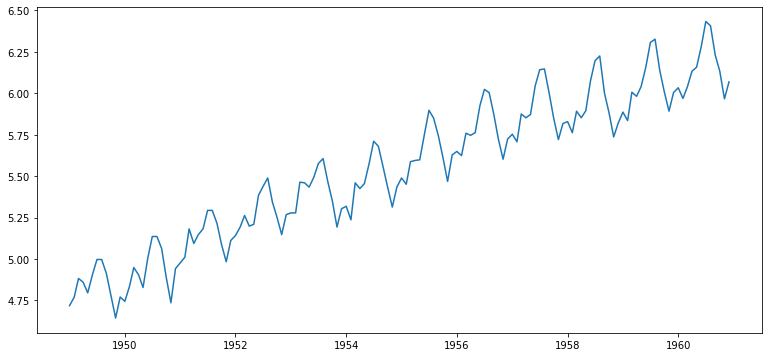

In [16]:
ts_log = np.log(ts2)
plt.plot(ts_log)

In [17]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.717017
p-value                          0.422367
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


### 1-2. Moving average 제거 - 추세 trend 상쇄하기

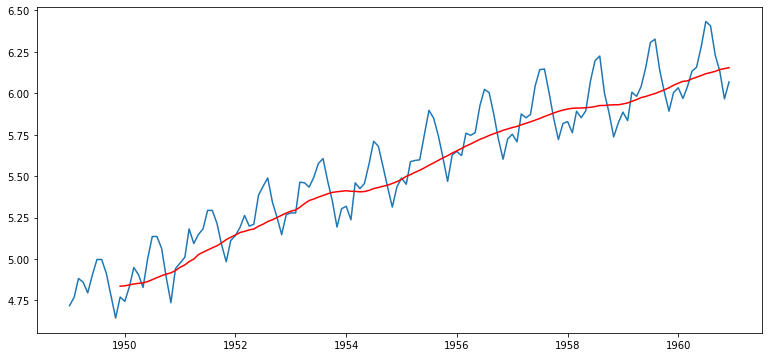

In [18]:
moving_avg = ts_log.rolling(window=12).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [19]:
ts_log_moving_avg = ts_log - moving_avg
ts_log_moving_avg.head(15)

Month
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
1949-06-01         NaN
1949-07-01         NaN
1949-08-01         NaN
1949-09-01         NaN
1949-10-01         NaN
1949-11-01         NaN
1949-12-01   -0.065494
1950-01-01   -0.093449
1950-02-01   -0.007566
1950-03-01    0.099416
Name: Passengers, dtype: float64

In [20]:
ts_log_moving_avg.dropna(inplace=True)
ts_log_moving_avg.head(15)

Month
1949-12-01   -0.065494
1950-01-01   -0.093449
1950-02-01   -0.007566
1950-03-01    0.099416
1950-04-01    0.052142
1950-05-01   -0.027529
1950-06-01    0.139881
1950-07-01    0.260184
1950-08-01    0.248635
1950-09-01    0.162937
1950-10-01   -0.018578
1950-11-01   -0.180379
1950-12-01    0.010818
1951-01-01    0.026593
1951-02-01    0.045965
Name: Passengers, dtype: float64

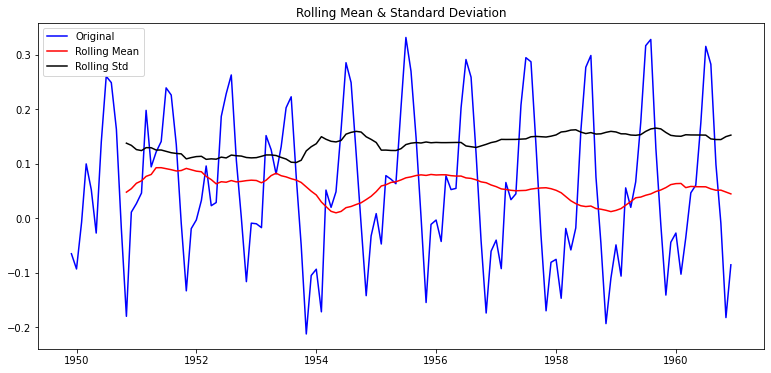

In [21]:
plot_rolling_statistics(ts_log_moving_avg)

In [22]:
augmented_dickey_fuller_test(ts_log_moving_avg)

Results of Dickey-Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


### 1-3. 차분 differencing - 계절성 Seasonality 상쇄하기

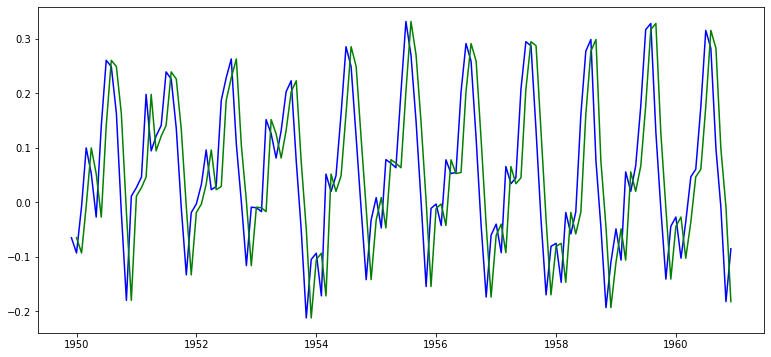

In [23]:
ts_log_moving_avg_shift = ts_log_moving_avg.shift()

plt.plot(ts_log_moving_avg, color='blue')
plt.plot(ts_log_moving_avg_shift, color='green')

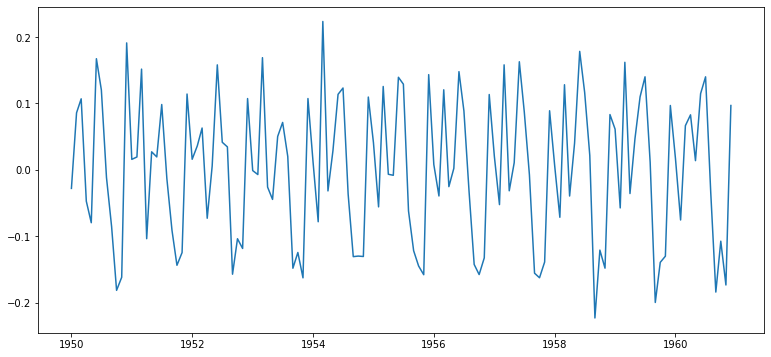

In [24]:
ts_log_moving_avg_dff = ts_log_moving_avg - ts_log_moving_avg_shift
ts_log_moving_avg_dff.dropna(inplace=True)
plt.plot(ts_log_moving_avg_dff)

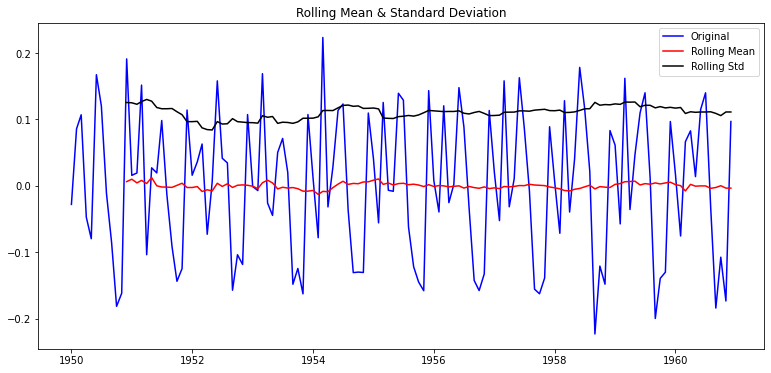

In [25]:
plot_rolling_statistics(ts_log_moving_avg_dff)

* Moving mean 으로 추세Trend 제거
* 1차 차분 1st order differencing 으로 계절성 seasonality 상쇄하여 p-value를 `0.022` 에서 `0.0019` 로 감소시킴
* 2차, 3차 차분 2nd, 3rd diff.


In [26]:
augmented_dickey_fuller_test(ts_log_moving_avg_dff)

Results of Dickey-Fuller Test:
Test Statistic                  -3.912981
p-value                          0.001941
#Lags Used                      13.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64


---
## 2. 시계열 분해 Time series decomposition

`seasonal_decompose` 메소드, trend, seasonality 분리

`Trend + Seasonality + Residual = Original`

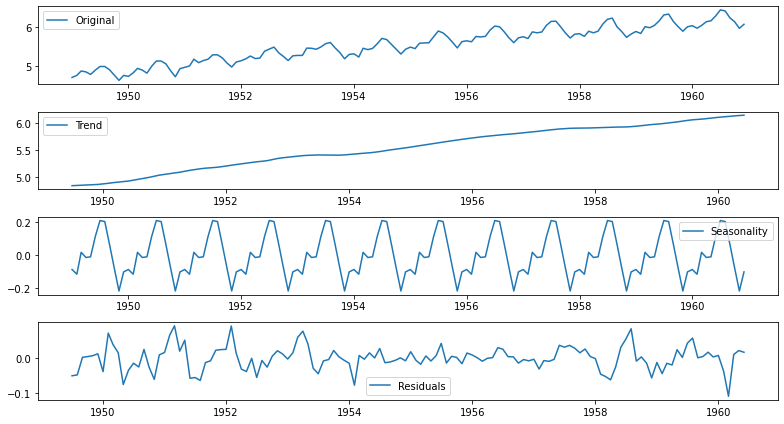

In [27]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid   # 원본(로그변환된) - 추세 - 계절성

plt.rcParams['figure.figsize'] = (11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

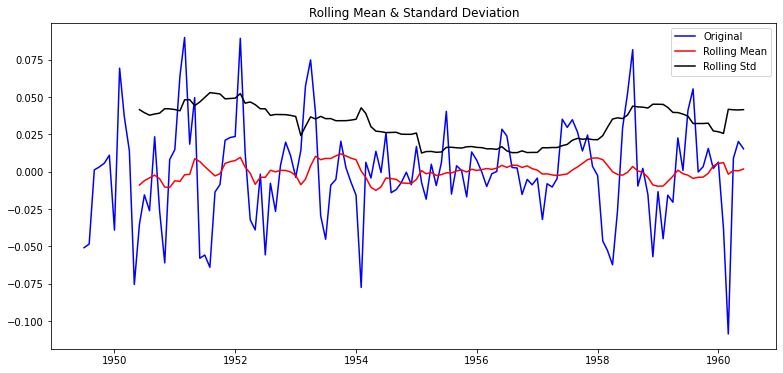

In [28]:
plt.rcParams['figure.figsize'] = (13,6)
plot_rolling_statistics(residual)

In [29]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


---
# ARIMA 모델
`ARIMA Autoregressive Integrated Moving Average`
1. AR (자기회귀, Autoregressive)
2. I (차분누적, Integration)
3. MA (이동평균, Moving Average)

* __파라미터 p, d, q__
    - p: 자기회귀 모형AR의 시차
    - d: 차분누적I의 횟수
    - q: 이동평균 모형MA의 시차
    - p + q < 2, p * q = 0

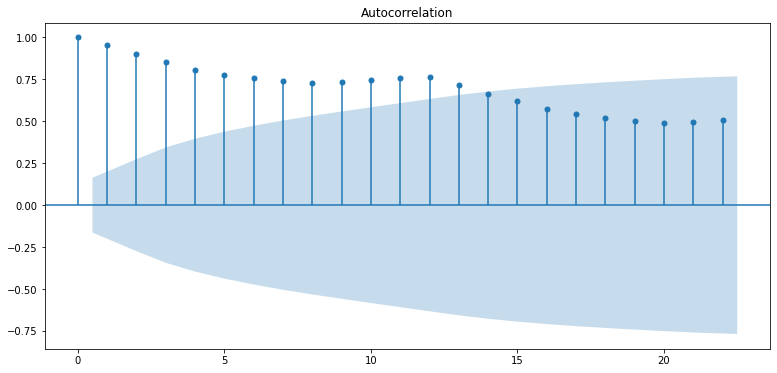

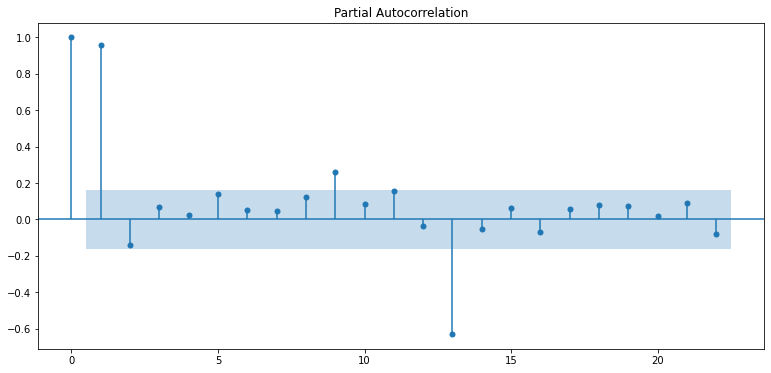

In [30]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프
plot_pacf(ts_log)   # PACF : Partial Autocorrelation 그래프
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


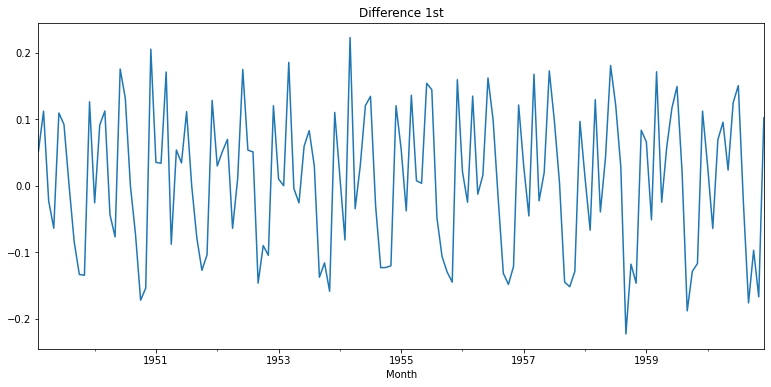

In [31]:
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -8.196629e+00
p-value                        7.419305e-13
#Lags Used                     1.300000e+01
Number of Observations Used    1.280000e+02
Critical Value (1%)           -3.482501e+00
Critical Value (5%)           -2.884398e+00
Critical Value (10%)          -2.578960e+00
dtype: float64


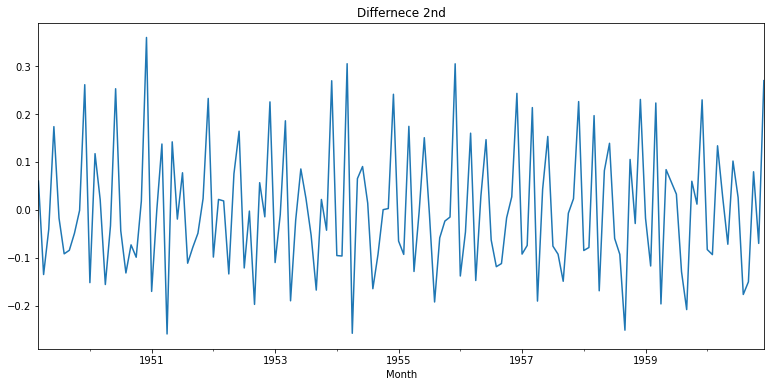

In [32]:
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Differnece 2nd')

augmented_dickey_fuller_test(diff_2)

---
## 학습 데이터 분리

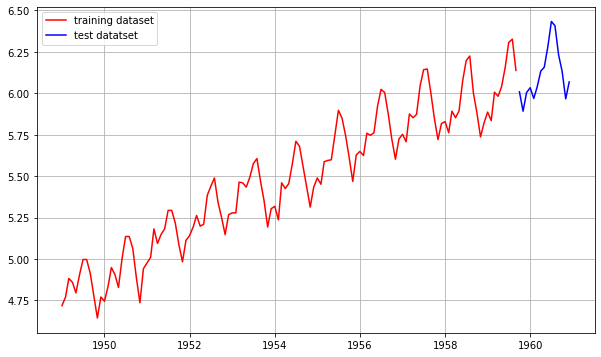

In [33]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(train_data, c='r', label='training dataset')
plt.plot(test_data, c='b', label='test datatset')
plt.legend()

## ARIMA 모델 훈련과 추론
* Parms: p=1, d=1, q=0

In [34]:
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train_data, order=(1,1,0))
fitted_m = model.fit()

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  129
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 107.558
Date:                Thu, 18 Nov 2021   AIC                           -211.117
Time:                        13:33:26   BIC                           -205.413
Sample:                    01-01-1949   HQIC                          -208.799
                         - 09-01-1959                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1853      0.100      1.852      0.064      -0.011       0.381
sigma2         0.0109      0.002      5.815      0.000       0.007       0.015
Ljung-Box (L1) (Q):                   0.07   Jarque-

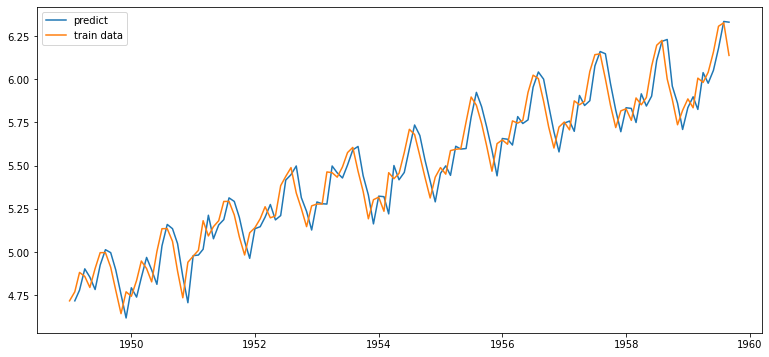

In [35]:
fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])
plt.plot(fitted_m, label='predict')
plt.plot(train_data, label='train data')
plt.legend()

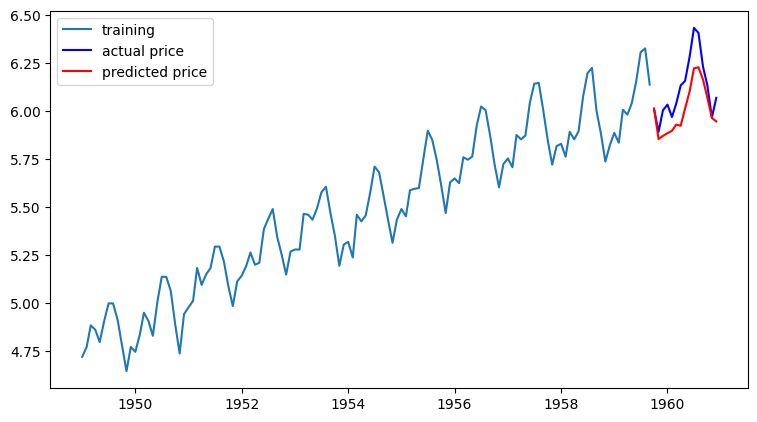

In [36]:
model = ARIMA(train_data, order=(10, 1, 0))  # p=10 으로 테스트
fitted_m = model.fit()
fc = fitted_m.forecast(len(test_data), alpha=0.05)

fc_series = pd.Series(fc, index=test_data.index)

plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r', label='predicted price')
plt.legend()
plt.show()

In [37]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  3749.5395750523307
MAE:  50.80662017710914
RMSE:  61.233484100223556
MAPE: 10.42%


---

# 주식 예측 도전!!
### Step 1: 시계열 데이터 준비
* 칼럼 종류 : Date, Open, High, Low, `Close`, Adj Close, Volume

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

file_path = os.getenv("HOME") + "/aiffel/stock_prediction/data/005930.KS.csv"

ts = pd.read_csv(file_path, usecols=['Date','Close'], index_col=['Date'], parse_dates=True)

ts.head()

,Close
Date,
2020-05-18,48800.0
2020-05-19,50300.0
2020-05-20,50000.0
2020-05-21,49950.0
2020-05-22,48750.0


### Step 2: 데이터 전처리

In [39]:
ts = ts.interpolate(method='time')
ts[ts.isna()]

,Close
Date,
2020-05-18,NaN
2020-05-19,NaN
2020-05-20,NaN
2020-05-21,NaN
2020-05-22,NaN
...,...
2021-05-12,NaN
2021-05-13,NaN
2021-05-14,NaN


In [40]:
ts_log = np.log(ts)

## Step 3: 시계열 안정성 분석

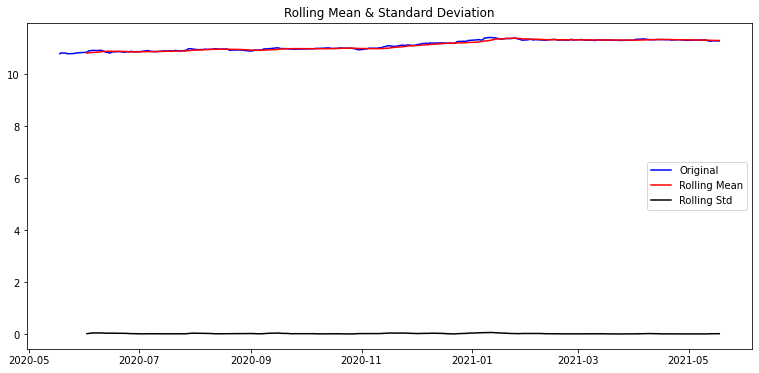

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


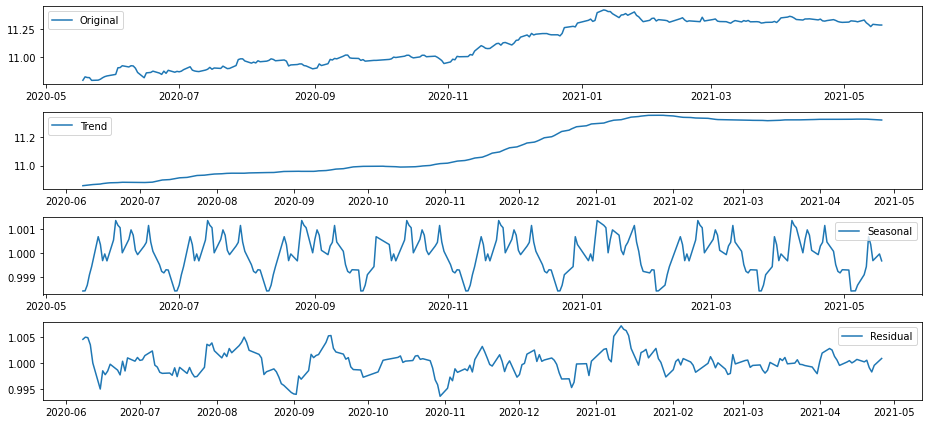

In [43]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

# 정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

# 시계열 분해 Time series decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period=30)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Seasonal')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residual')
plt.legend()
plt.tight_layout()

In [42]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


## Step 4: 학습, 테스트 데이터셋 생성
* 학습 테스트 데이터셋 분리

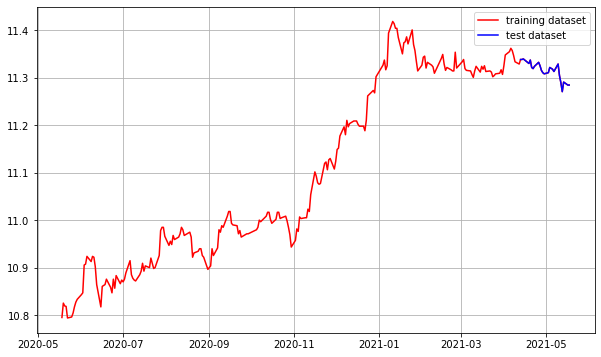

In [47]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

## Step 5: 적정 ARIMA 모수 찾기

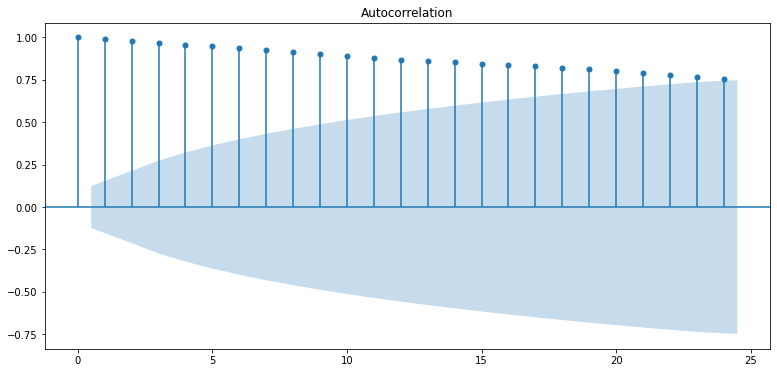

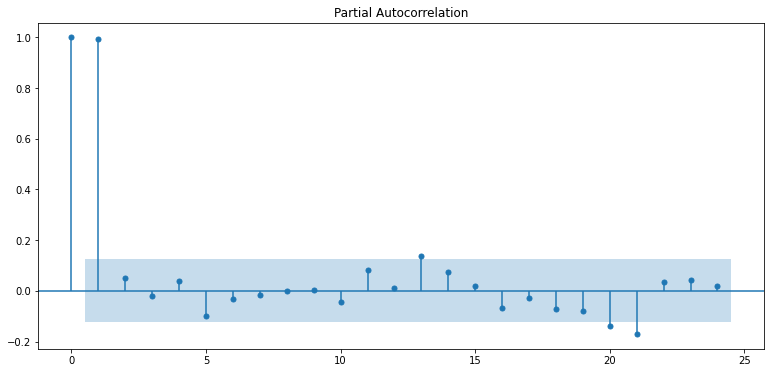

In [49]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)
plot_pacf(ts_log)
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.029320e+01
p-value                        3.525823e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


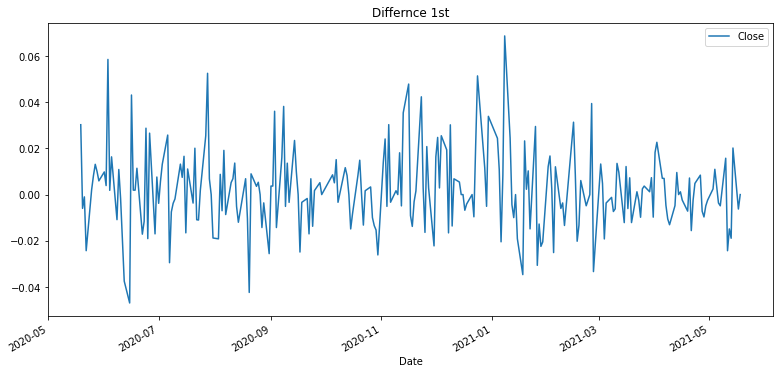

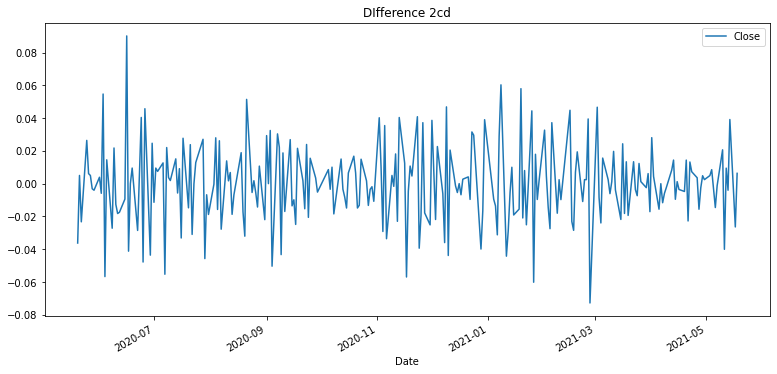

In [51]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Differnce 1st')

augmented_dickey_fuller_test(diff_1)

# 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='DIfference 2cd')

augmented_dickey_fuller_test(diff_2)

## Step 6: ARIMA 모델 훈련과 테스트
* ARIMA 모델 빌드와 훈련
* 모델 테스트 및 플로팅
* 최종 예측 모델 정확도 측정(MAPE)

In [52]:
from statsmodels.tsa.arima_model import ARIMA

# Build model
model = ARIMA(train_data, order=(1,1,0))
fitted_m = model.fit(disp=-1)
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  224
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 585.396
Method:                       css-mle   S.D. of innovations              0.018
Date:                Thu, 18 Nov 2021   AIC                          -1164.792
Time:                        13:45:02   BIC                          -1154.557
Sample:                             1   HQIC                         -1160.661
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0024      0.001      1.978      0.048    2.17e-05       0.005
ar.L1.D.Close     0.0168      0.067      0.250      0.803      -0.115       0.148
                                    Root

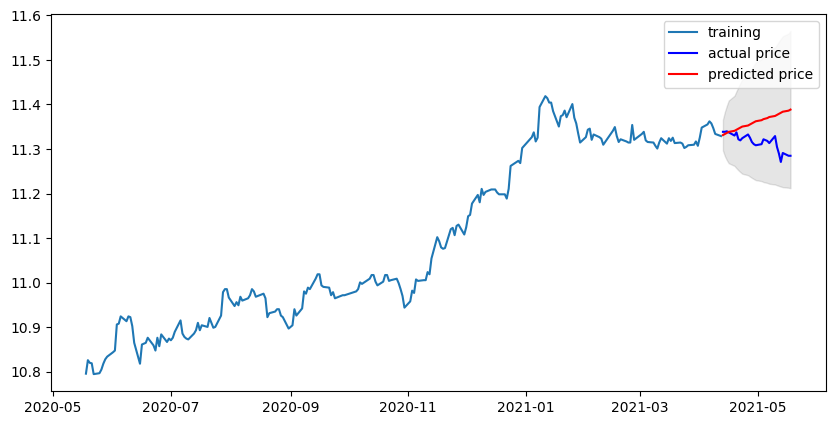

In [53]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [74]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  22087366.126154922
MAE:  3791.3511527213127
RMSE:  4699.719792301976


ValueError: Unable to coerce to Series, length must be 1: given 25

## Step 7: 다른 주식 종목 예측해보기

In [62]:
print(fc.reshape(-1,1).shape)
print(test_data.shape)

(25, 1)
(25, 1)


In [75]:
mape

2021-04-13 00:00:00   NaN
2021-04-14 00:00:00   NaN
2021-04-15 00:00:00   NaN
2021-04-16 00:00:00   NaN
2021-04-19 00:00:00   NaN
2021-04-20 00:00:00   NaN
2021-04-21 00:00:00   NaN
2021-04-22 00:00:00   NaN
2021-04-23 00:00:00   NaN
2021-04-26 00:00:00   NaN
2021-04-27 00:00:00   NaN
2021-04-28 00:00:00   NaN
2021-04-29 00:00:00   NaN
2021-04-30 00:00:00   NaN
2021-05-03 00:00:00   NaN
2021-05-04 00:00:00   NaN
2021-05-06 00:00:00   NaN
2021-05-07 00:00:00   NaN
2021-05-10 00:00:00   NaN
2021-05-11 00:00:00   NaN
2021-05-12 00:00:00   NaN
2021-05-13 00:00:00   NaN
2021-05-14 00:00:00   NaN
2021-05-17 00:00:00   NaN
2021-05-18 00:00:00   NaN
Close                 NaN
dtype: float64